In [3]:
import os
import sys
import pandas as pd
import re, json
import pytesseract
import matplotlib.pyplot as plt


from dotenv import load_dotenv
from PIL import Image
from tempfile import NamedTemporaryFile
from io import BytesIO


project_root = os.path.abspath("..")
sys.path.append(project_root) 
load_dotenv(os.path.join(project_root, ".env"))
api_key = os.getenv("GENAI_API_KEY")
api_ocr_key = os.getenv("BG_OCR_API_KEY")
api_ocr_key2 = os.getenv("OCR_API_KEY")

from utils.utils import (
    VisionLanguageModel,
    DataUtils,
    prepare_content,
    get_answers_chunked,
    make_gold_file_json,
    visualize_image,
    get_answers, 
    extract_answer_bg,
    postprocess_regex,
    postprocess_regex_bg, 
    make_gold_file_json_bg
)

from utils.ocr import (
    ocr_space_file,
    ocr_df
)

In [4]:
vlm = VisionLanguageModel(api_key=api_key)

In [5]:
# df = DataUtils.load_parquet("../eval_pqs/bg_test.parquet")

In [6]:
# df

In [7]:
# ocr_col = ocr_df(df, lang="bul")

In [8]:
# df['ocr_text'] = ocr_col

In [9]:
# df

In [10]:
# df.to_parquet("../eval_pqs/bg_test_ocr.parquet", index=False)
df = DataUtils.load_parquet("../eval_pqs/bg_test_ocr.parquet")
df

Loaded DataFrame from ../eval_pqs/bg_test_ocr.parquet, shape=(200, 12)


,type,grade,subject,language,chemical_structure,table,figure,graph,sample_id,image,answer_key,ocr_text
0,image_text,12,History,Bulgarian,0,0,1,0,54e1aeca-4ef1-47e3-af20-4d8c9edee5ae,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,None,1. Кое от изображенията НЕ е пример за приноса...
1,image_text,12,History,Bulgarian,0,0,1,0,6869ad38-97e7-4576-951b-7b537a40f029,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,None,4. Коя фраза синтезира идеята за императорскат...
2,text,12,History,Bulgarian,0,0,0,0,1c6bf0f9-0e69-4846-8806-bf71aec9e7f5,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,None,2. За коя древнотракииска практика дава информ...
3,text,12,History,Bulgarian,0,0,0,0,de585dbc-0da3-4625-baa6-ef280abbe3ab,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,None,3. Каква промяна извършва император Геодосии Г...
4,image_text,12,History,Bulgarian,0,0,1,0,e4002c2e-def5-4536-ab18-5990e9ca5355,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,None,5. Кое произведение на изкуството е създадено ...
...,...,...,...,...,...,...,...,...,...,...,...,...
195,text,12,Mathematics,Bulgarian,0,0,0,0,1786d320-925a-4a35-a2a7-7ce614b7c26e,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,None,"д2х -5х+2\n------, акох< 2\n11. Дадена е функц..."
196,text,12,Mathematics,Bulgarian,0,0,0,0,855364ac-21d4-4724-874d-d8c5d6d2b3a7,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,None,12. Намерете границата ши\nх->0\n\n4 1\nА) - Б...
197,text,12,Mathematics,Bulgarian,0,0,0,0,ea93ffcc-63cb-4fa2-b8b4-77b86562b253,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,None,13. Абсцисата на инфлексната точка за функцият...
198,text,12,Mathematics,Bulgarian,0,0,0,0,ac085692-6f5c-47ef-a211-ccc9b0332d80,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,None,14. Ако в правилна триъгълна призма с основен ...


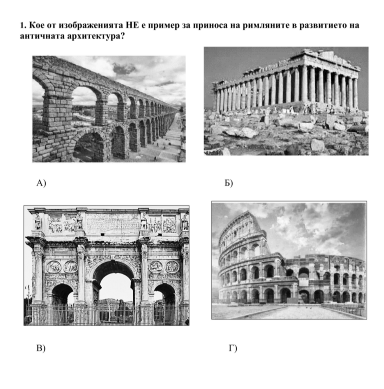

In [11]:
visualize_image(df.iloc[0]['image']['bytes'])

In [13]:
answers2, failures2 = get_answers_chunked(
    df=df,
    vlm=vlm,
    model="gemini-2.0-flash",
    strict=True, 
    language="bg",
    ocr_enrichment=True,
    step=10,
    thinking=False,
)
print(f"Got {len(answers2)} answers, failed on rows: {failures2}")

Got 200 answers, failed on rows: []


In [27]:
df.columns

Index(['type', 'grade', 'subject', 'language', 'chemical_structure', 'table',
       'figure', 'graph', 'sample_id', 'image', 'answer_key', 'ocr_text'],
      dtype='object')

In [22]:
[(i, ans) for i, ans in enumerate(answers2) if ans['answer_key'] not in ['А', 'Б', 'В', 'Г', 'Д']]

[(61,
  {'id': 'e636f26d-d636-41ee-83f7-d195852afd62',
   'answer_key': '2. Кое от следните изображения НЕ е икона?\nА) „Св. Георги“ – края на XV в.\nБ) Рафаел Санти „Св. Георги“, 1506 г.\nВ) „Св. Мина“, 1823 г.\nГ) Зограф поп Димитър „Св. Георги“, 1838 г.\n\nБ',
   'language': 'Bulgarian'})]

In [23]:
answers2[61]['answer_key'] = 'Б'

In [17]:
for ans in answers2:
    match ans["answer_key"]:
        case "A":
            ans["answer_key"] = "А"
        case "B":
            ans["answer_key"] = "Б"
        case "C":
            ans["answer_key"] = "В"
        case "D":
            ans["answer_key"] = "Г"
        case "V":
            ans["answer_key"] = "В"
        case "G":
            ans["answer_key"] = "Г"

In [ ]:
for ans in answers2:
    match ans["answer_key"]:
        case "А" | 'а':
            ans["answer_key"] = "A"
        case "Б" | 'б':
            ans["answer_key"] = "B"
        case "В" | 'в':
            ans["answer_key"] = "C"
        case "Г" | 'г':
            ans["answer_key"] = "D"
        case "Д" | 'д':
            ans["answer_key"] = "E"

In [29]:
len([ans for ans in answers2 if ans['answer_key'] not in ['A', 'B', 'C', 'D', 'E']])

0

In [26]:
with open("../outputs/predictions-test-bg-gemini-2.0-flash.json", "w") as f:
    json.dump(answers2, f, ensure_ascii=False, indent=4)

In [28]:
len(answers2)

200

In [31]:
answers3, failures3 = get_answers_chunked(
    df=df,
    vlm=vlm,
    model="gemini-2.5-flash-preview-04-17",
    strict=True, 
    language="bg",
    ocr_enrichment=True,
    step=10,
    thinking=True,
)
print(f"Got {len(answers3)} answers, failed on rows: {failures3}")

Error in _generate: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}
Attempt 1 for get_answer failed: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}. Retrying in 1.0s...
Got 200 answers, failed on rows: []


In [34]:
[(i, ans) for i, ans in enumerate(answers3) if ans['answer_key'] not in ['А', 'Б', 'В', 'Г', 'Д']]

[]

In [36]:
for ans in answers3:
    match ans["answer_key"]:
        case "А" | 'а':
            ans["answer_key"] = "A"
        case "Б" | 'б':
            ans["answer_key"] = "B"
        case "В" | 'в':
            ans["answer_key"] = "C"
        case "Г" | 'г':
            ans["answer_key"] = "D"
        case "Д" | 'д':
            ans["answer_key"] = "E"

In [37]:
answers3

[{'id': '54e1aeca-4ef1-47e3-af20-4d8c9edee5ae',
  'answer_key': 'B',
  'language': 'Bulgarian'},
 {'id': '6869ad38-97e7-4576-951b-7b537a40f029',
  'answer_key': 'A',
  'language': 'Bulgarian'},
 {'id': '1c6bf0f9-0e69-4846-8806-bf71aec9e7f5',
  'answer_key': 'C',
  'language': 'Bulgarian'},
 {'id': 'de585dbc-0da3-4625-baa6-ef280abbe3ab',
  'answer_key': 'B',
  'language': 'Bulgarian'},
 {'id': 'e4002c2e-def5-4536-ab18-5990e9ca5355',
  'answer_key': 'B',
  'language': 'Bulgarian'},
 {'id': '173c6910-3c9c-4603-a1ef-82839d3279d9',
  'answer_key': 'D',
  'language': 'Bulgarian'},
 {'id': 'eb7ce792-4e4b-49ea-b0dc-668b92b2d965',
  'answer_key': 'D',
  'language': 'Bulgarian'},
 {'id': 'd7d77939-608c-4640-927d-7c841b3a0a36',
  'answer_key': 'B',
  'language': 'Bulgarian'},
 {'id': 'c580c73b-b5f6-4037-be06-bf76658973ea',
  'answer_key': 'D',
  'language': 'Bulgarian'},
 {'id': 'aa3ee85b-8883-4fd8-97db-cab61775874b',
  'answer_key': 'C',
  'language': 'Bulgarian'},
 {'id': '1688e38b-3f19-4675-94

In [38]:
len([ans for ans in answers3 if ans['answer_key'] not in ['A', 'B', 'C', 'D', 'E']])

0

In [39]:
with open("../outputs/predictions-test-bg-gemini-2.5-flash.json", "w") as f:
    json.dump(answers3, f, ensure_ascii=False, indent=4)